In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


#**Importação e análise dos dados**

In [ ]:
core_idg = ImageDataGenerator(samplewise_center=False,
                              samplewise_std_normalization=False,
                              horizontal_flip=True,
                              vertical_flip=False,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              #brightness_range=[0.7, 1.5],
                              rotation_range=30,
                              #shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              #validation_split = 0.25,
                              rescale = 1./255
                              )

core_idg_test = ImageDataGenerator(samplewise_center=False,
                              samplewise_std_normalization=False,
                              horizontal_flip=False,
                              vertical_flip=False,
                              #height_shift_range=0.1,
                              #width_shift_range=0.1,
                              #brightness_range=[0.7, 1.5],
                              #rotation_range=3,
                              #shear_range=0.01,
                              fill_mode='nearest',
                              #zoom_range=0.125,
                              rescale = 1./255
                              )

In [ ]:
import pathlib

dataset_url_training = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Training"
dataset_url_test = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Test"
dataset_url_validation = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Validation"

data_dir_training = pathlib.Path(dataset_url_training)
data_dir_validation = pathlib.Path(dataset_url_validation)
data_dir_test = pathlib.Path(dataset_url_test)

image_count_training = len(list(data_dir_training.glob('*/*.jpg')))
image_count_validation = len(list(data_dir_validation.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

print(f'Quantidade de imagens na base de treinamento:', image_count_training)
print(f'Quantidade de imagens na base de validação:', image_count_validation)
print(f'Quantidade de imagens na base de teste:', image_count_test)

Quantidade de imagens na base de treinamento: 900
Quantidade de imagens na base de validação: 240
Quantidade de imagens na base de teste: 60


In [ ]:
img_height = 299
img_width = 299
batch_size = 32

In [ ]:
train_generator = core_idg.flow_from_directory(dataset_url_training,
                                               target_size = (img_height, img_width),
                                               batch_size = batch_size,
                                               save_format='jpg',
                                               class_mode = 'sparse'
                                               )

train_generator.class_indices

Found 900 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

In [ ]:
val_generator = core_idg.flow_from_directory(dataset_url_validation,
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             save_format='jpg',
                                             class_mode = 'sparse')

val_generator.class_indices

Found 240 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

In [ ]:
test_generator = core_idg_test.flow_from_directory(dataset_url_test,
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             save_format='jpg',
                                             class_mode = 'sparse'
                                             )

test_generator.class_indices

Found 60 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

#**Modelo Xception**

##*Treinamento*

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

num_classes = 4

model_Xception = tf.keras.applications.xception.Xception(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=1000,
    classifier_activation='softmax',
)

model_Xception.Trainable = False

early_stopping = EarlyStopping(
    min_delta = 0.00001,
    monitor = 'val_loss',
    patience=16,
    restore_best_weights=True,
    mode = 'min'
)

path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_800.hdf5"

check_point = ModelCheckpoint(
    path_check_point_Xception,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.7,
                              patience = 5,
                              min_lr=0.0001)

model_Xception.compile(
  optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.007),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

epochs = 600

history = model_Xception.fit(
  train_generator,
  steps_per_epoch = STEP_SIZE_TRAIN,
  validation_data = val_generator,
  validation_steps = STEP_SIZE_VALID,
  epochs=epochs,
  callbacks=[early_stopping, check_point, reduce_lr],
  workers = 3
)

Epoch 1/600
18/18 [==============================] - ETA: 0s - loss: 6.5900 - accuracy: 0.0088
Epoch 1: val_loss improved from inf to 6.61247, saving model to /content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_800.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 103s 5s/step - loss: 6.5900 - accuracy: 0.0088 - val_loss: 6.6125 - val_accuracy: 0.0000e+00 - lr: 0.0070
Epoch 2/600
18/18 [==============================] - ETA: 0s - loss: 4.3995 - accuracy: 0.1849
Epoch 2: val_loss improved from 6.61247 to 4.35990, saving model to /content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_800.hdf5
18/18 [==============================] - 46s 2s/step - loss: 4.3995 - accuracy: 0.1849 - val_loss: 4.3599 - val_accuracy: 0.1125 - lr: 0.0070
Epoch 3/600
18/18 [==============================] - ETA: 0s - loss: 2.4482 - accuracy: 0.5493
Epoch 3: val_loss improved from 4.35990 to 2.80887, saving model to /content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_800.hdf5
18/18 [==============================] - 48s 3s/step - loss: 2.4482 - accuracy: 0.5493 - val_loss: 2.8089 - val_accuracy: 0.3250 - lr: 0.0070
Epoch 4/600
18/18 [==================

##*Teste - 4396 imagens*

Teste com um total de 4396 imagens, sendo, por classe, 3296 para treinamento, 800 para validação e 220 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

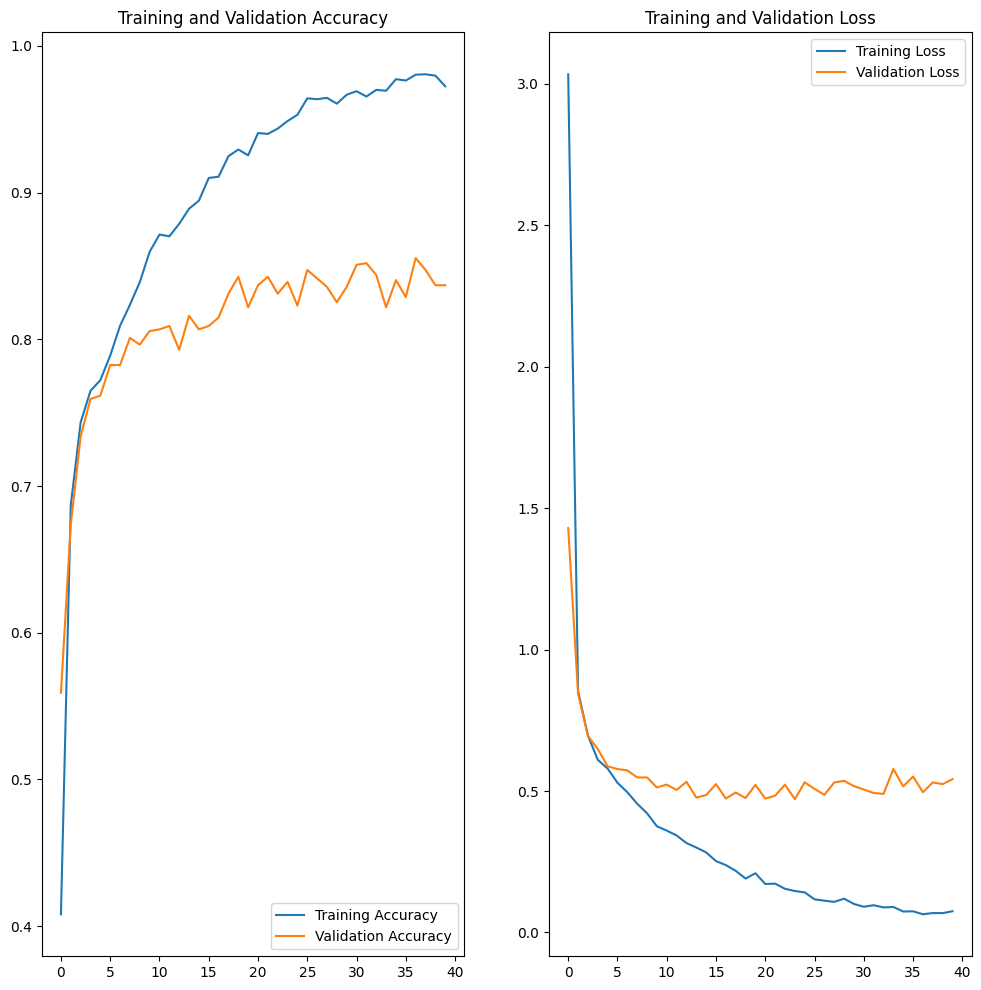

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_4396_v2.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

7/7 [==============================] - 15s 576ms/step


In [ ]:
model_test_Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

7/7 [==============================] - 6s 650ms/step - loss: 0.4816 - accuracy: 0.8318
              precision    recall  f1-score   support

         bcc       0.98      0.95      0.96        55
         bkl       0.74      0.84      0.79        55
         mel       0.75      0.82      0.78        55
          nv       0.89      0.73      0.80        55

    accuracy                           0.83       220
   macro avg       0.84      0.83      0.83       220
weighted avg       0.84      0.83      0.83       220



Erro: 0.48 
Acurácia: 0.83


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 55, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(55, 110, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(110, 165, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(165, 220, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

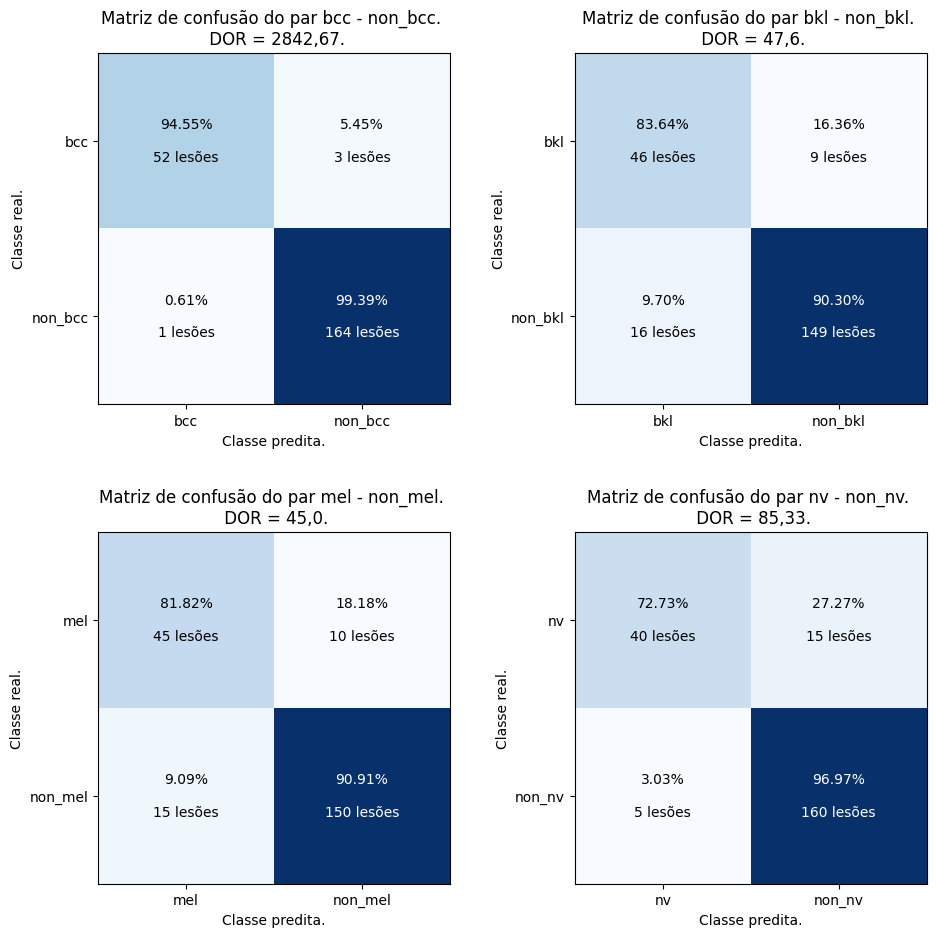

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/55, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/165, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

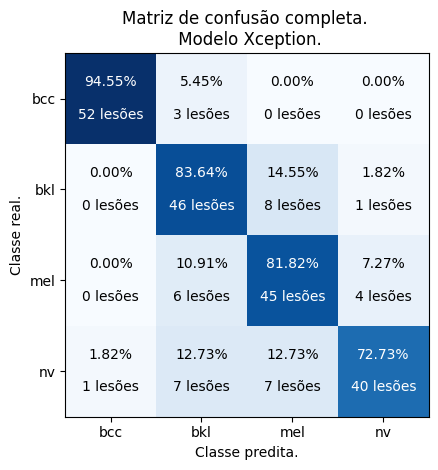

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*55, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

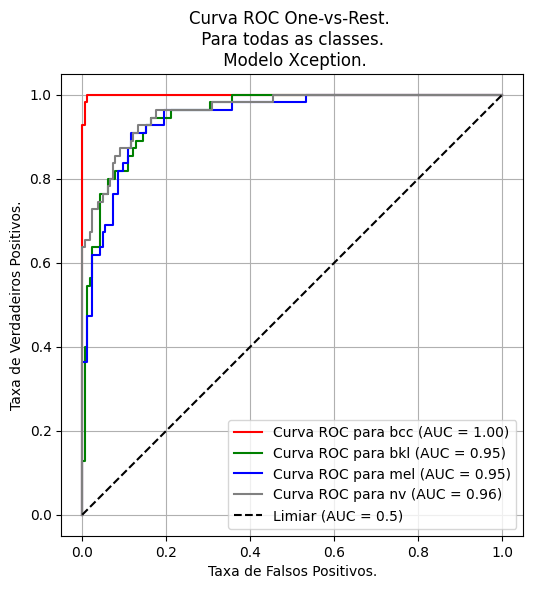

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 4000 imagens*

Teste com um total de 4000 imagens, sendo, por classe, 3000 para treinamento, 800 para validação e 200 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

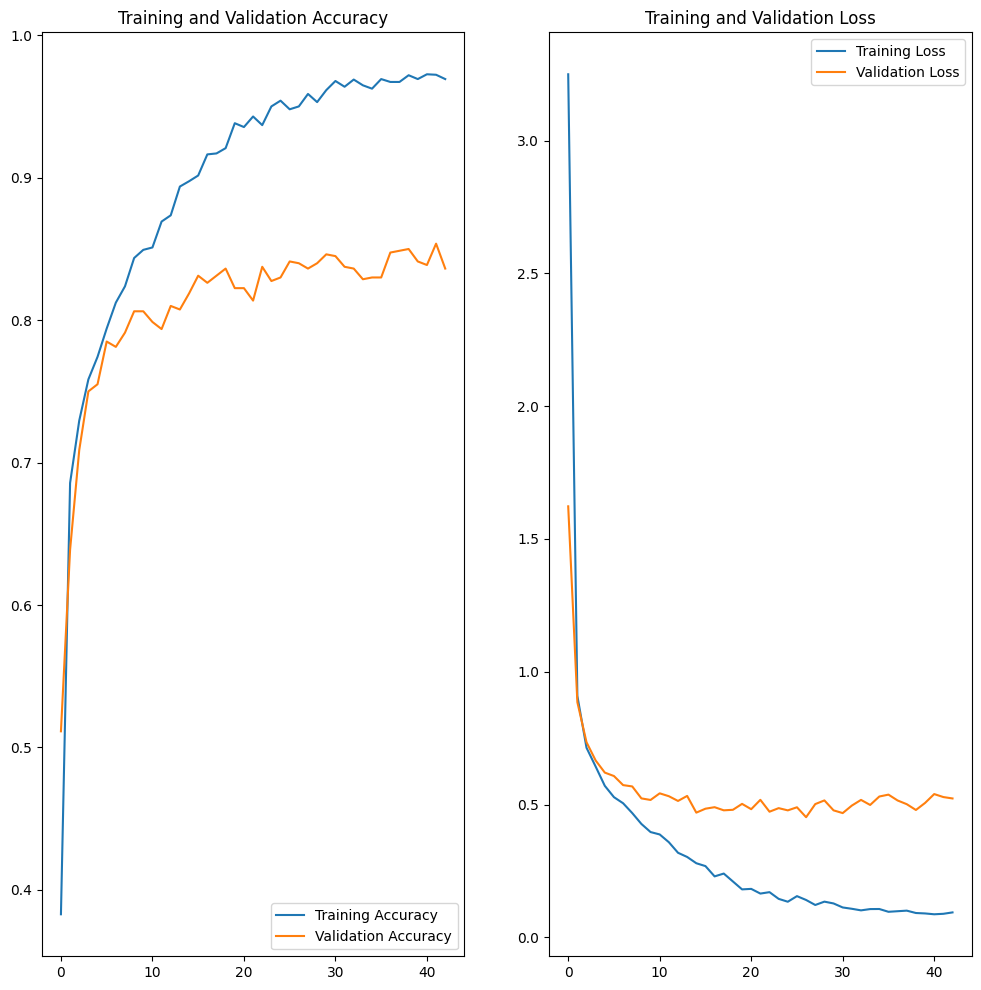

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(43)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_4000.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

7/7 [==============================] - 12s 313ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

7/7 [==============================] - 4s 370ms/step - loss: 0.5865 - accuracy: 0.8400
              precision    recall  f1-score   support

         bcc       0.98      0.96      0.97        50
         bkl       0.77      0.86      0.81        50
         mel       0.76      0.84      0.80        50
          nv       0.88      0.70      0.78        50

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



Erro: 0.59 
Acurácia: 0.84


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 50, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(50, 100, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(100, 150, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(150, 200, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

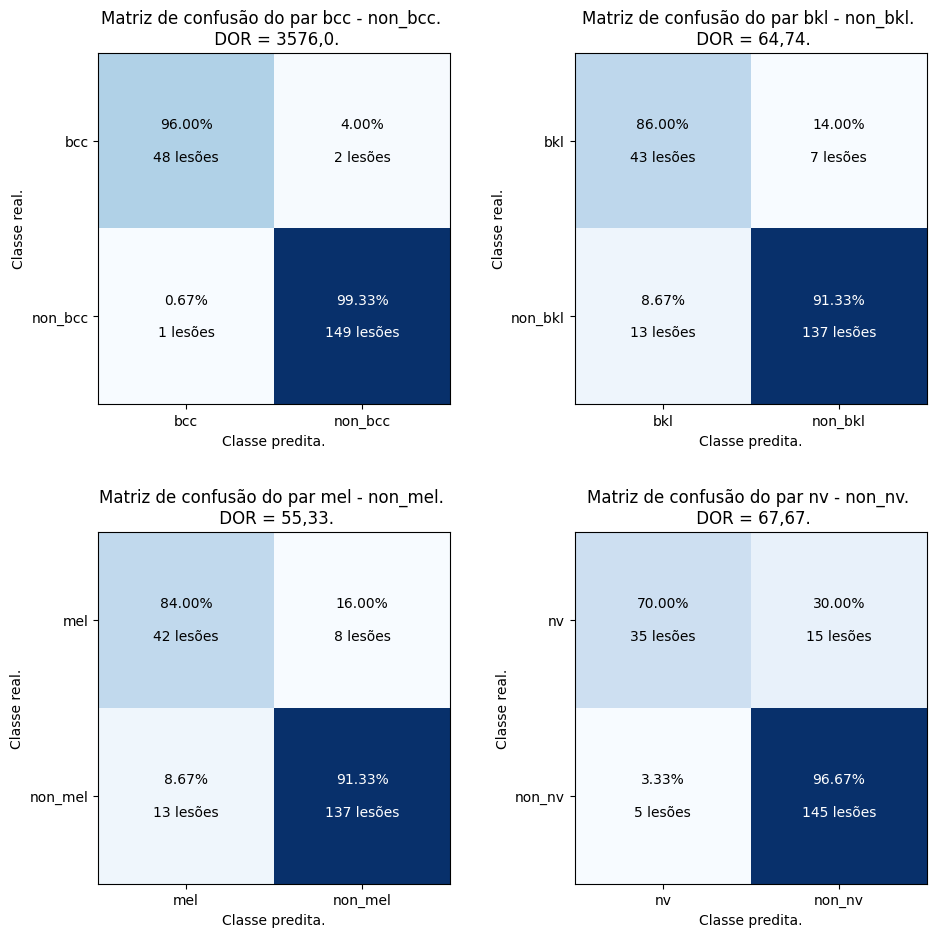

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/50, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/150, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

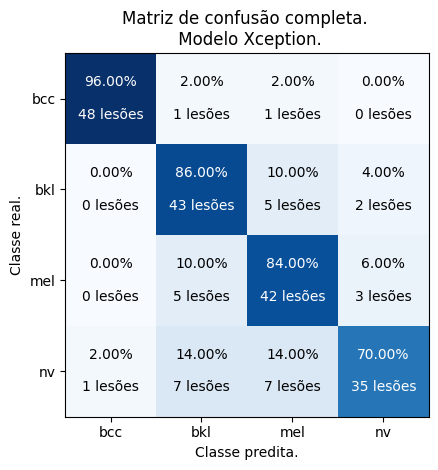

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*50, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

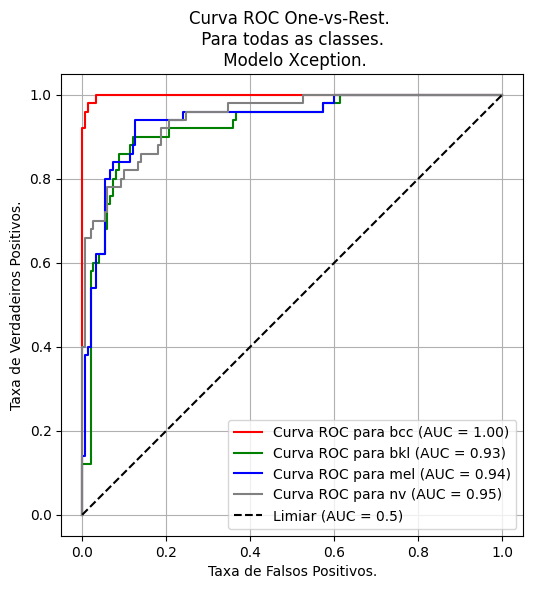

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 3600 imagens*

Teste com um total de 3600 imagens, sendo, por classe, 2700 para treinamento, 720 para validação e 180 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

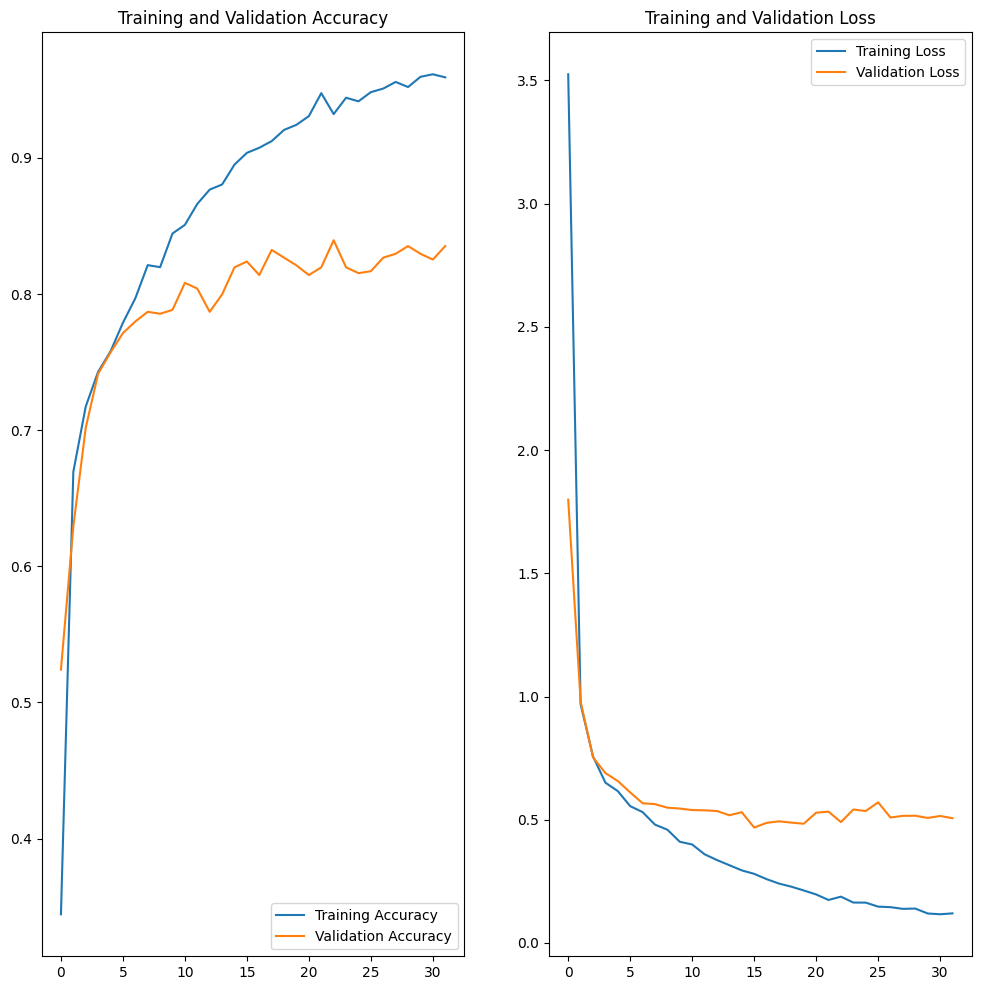

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

6/6 [==============================] - 40s 6s/step


In [ ]:
model_test_Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

6/6 [==============================] - 39s 6s/step - loss: 0.4815 - accuracy: 0.8056
              precision    recall  f1-score   support

         bcc       0.95      0.93      0.94        45
         bkl       0.70      0.82      0.76        45
         mel       0.76      0.78      0.77        45
          nv       0.84      0.69      0.76        45

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180



Erro: 0.48 
Acurácia: 0.81


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 45, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(45, 90, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(90, 135, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(135, 180, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

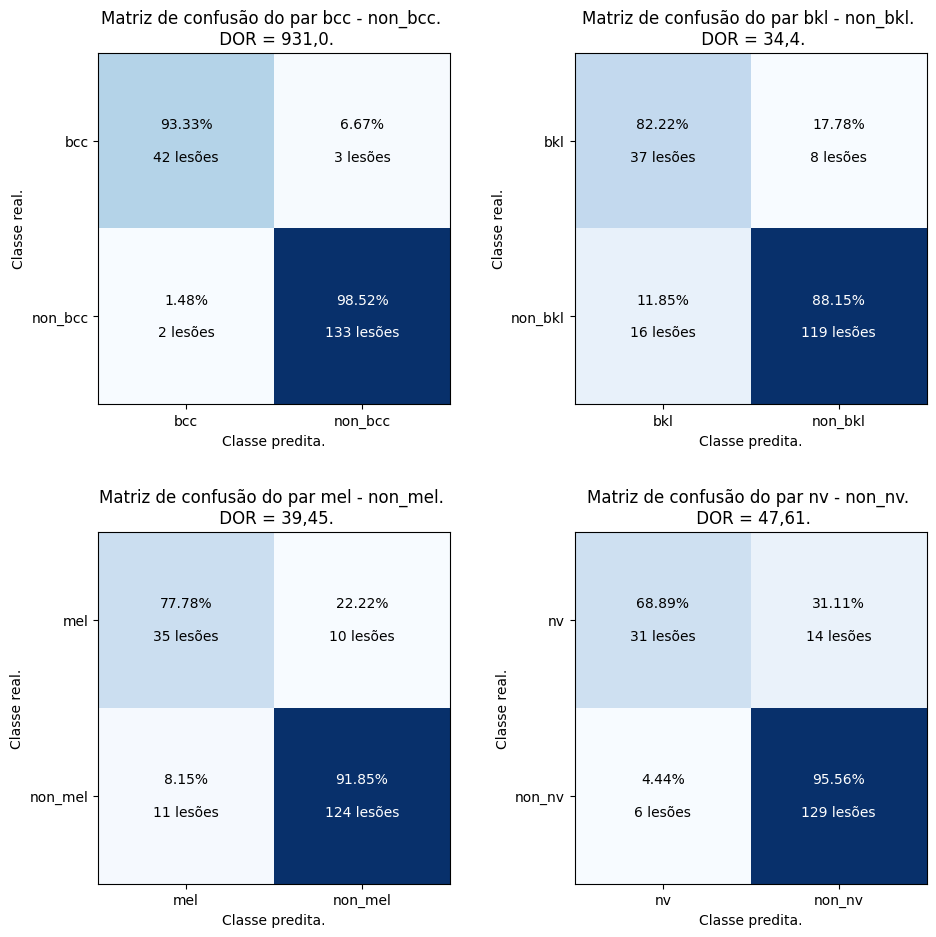

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/45, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/135, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

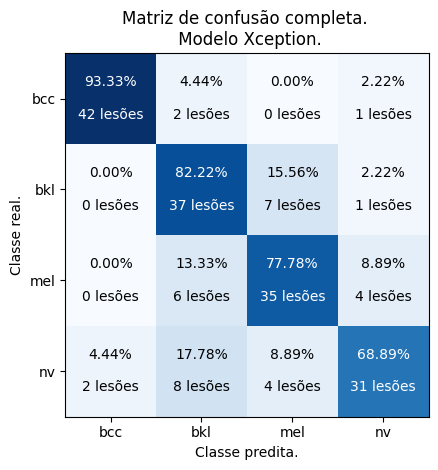

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*45, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

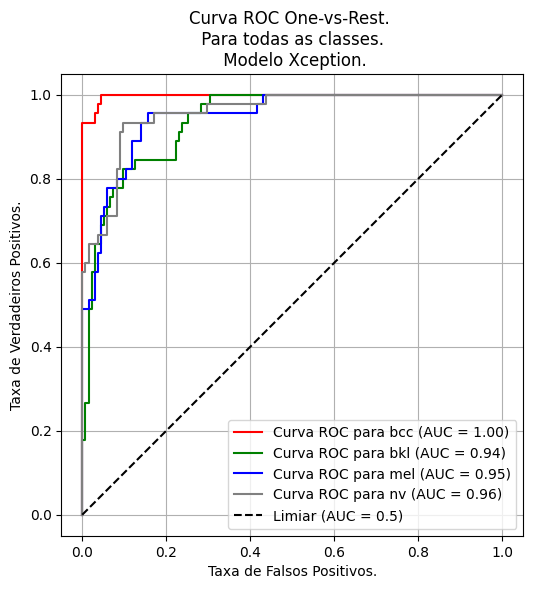

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 3200 imagens*

Teste com um total de 3200 imagens, sendo, por classe, 2400 para treinamento, 640 para validação e 160 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

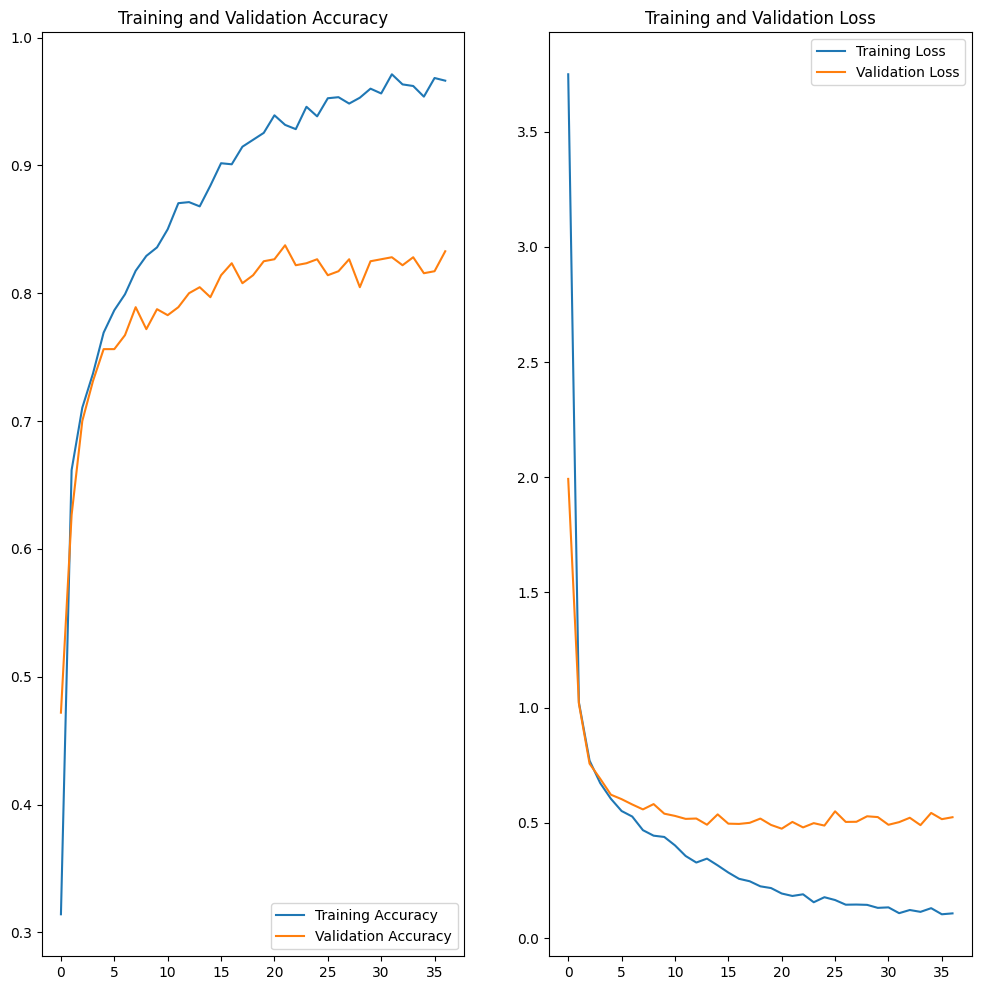

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(37)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

5/5 [==============================] - 2s 253ms/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

5/5 [==============================] - 4s 482ms/step - loss: 0.5416 - accuracy: 0.8188
              precision    recall  f1-score   support

         bcc       0.97      0.95      0.96        40
         bkl       0.73      0.88      0.80        40
         mel       0.80      0.70      0.75        40
          nv       0.79      0.75      0.77        40

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160



Erro: 0.54 
Acurácia: 0.82


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 40, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(40, 80, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(80, 120, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(120, 160, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

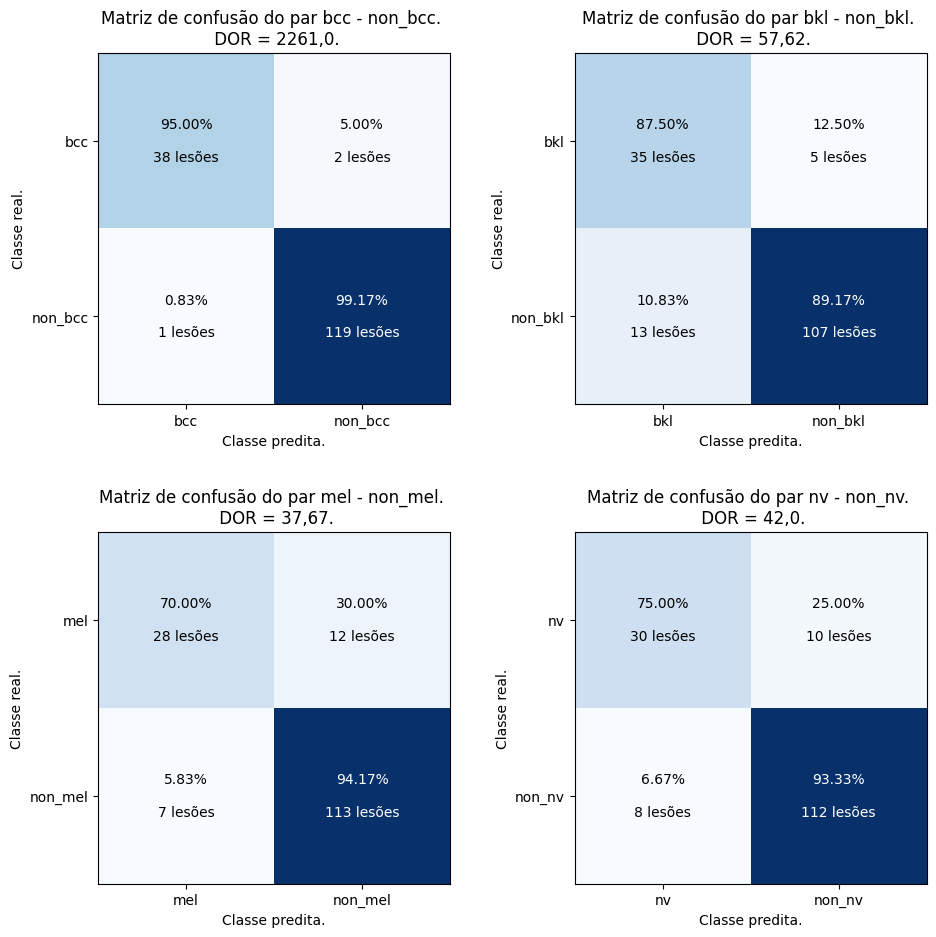

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/40, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/120, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

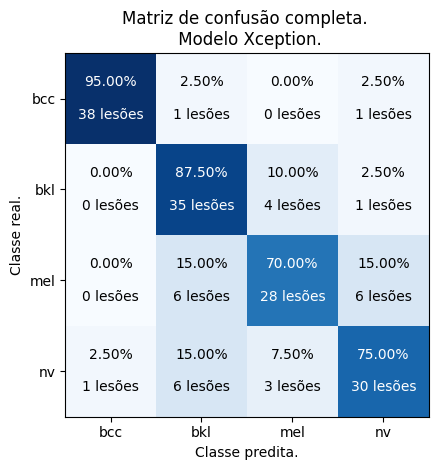

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*40, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

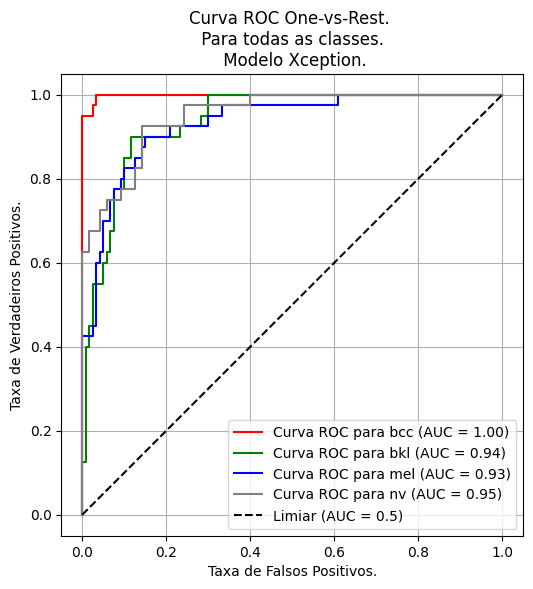

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2800 imagens*

Teste com um total de 2800 imagens, sendo, por classe, 2100 para treinamento, 560 para validação e 140 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

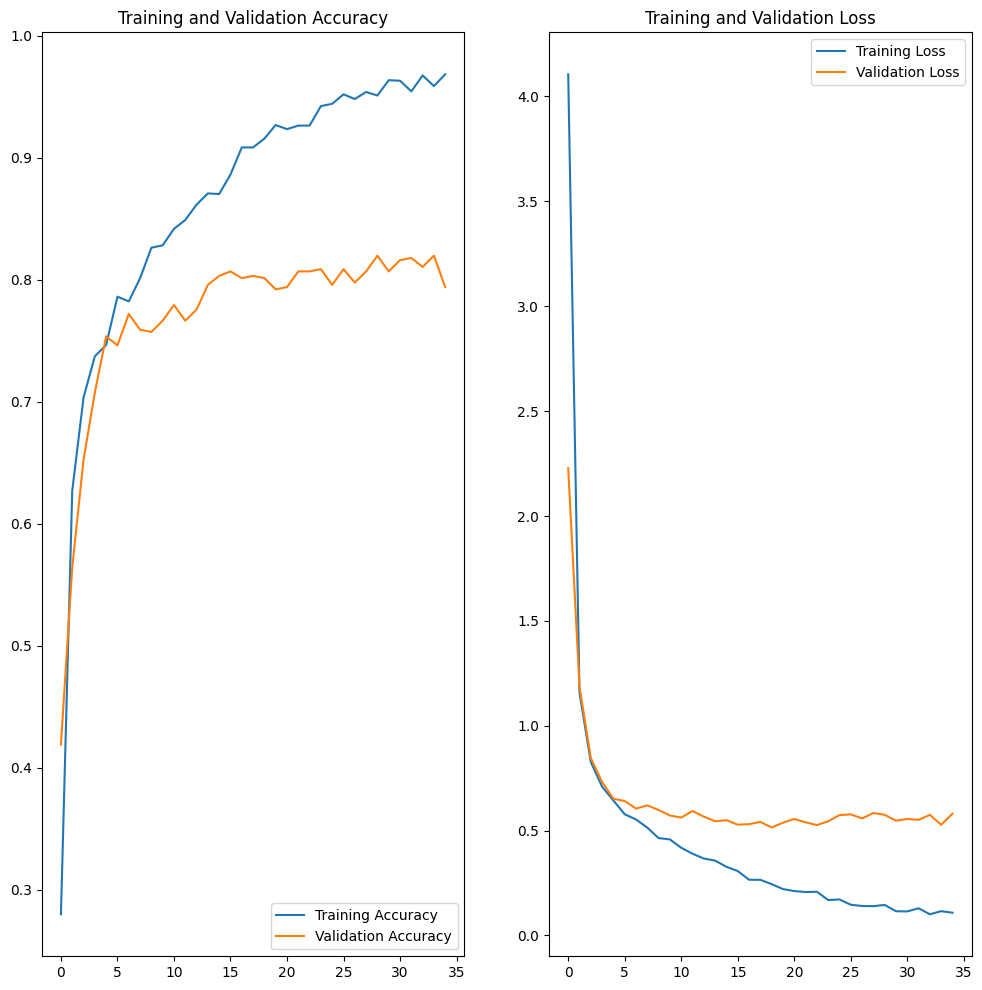

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

5/5 [==============================] - 3s 597ms/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

5/5 [==============================] - 4s 412ms/step - loss: 0.4958 - accuracy: 0.8143
              precision    recall  f1-score   support

         bcc       0.89      0.97      0.93        35
         bkl       0.74      0.80      0.77        35
         mel       0.77      0.77      0.77        35
          nv       0.86      0.71      0.78        35

    accuracy                           0.81       140
   macro avg       0.82      0.81      0.81       140
weighted avg       0.82      0.81      0.81       140



Erro: 0.50 
Acurácia: 0.81


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 35, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(35, 70, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(70, 105, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(105, 140, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

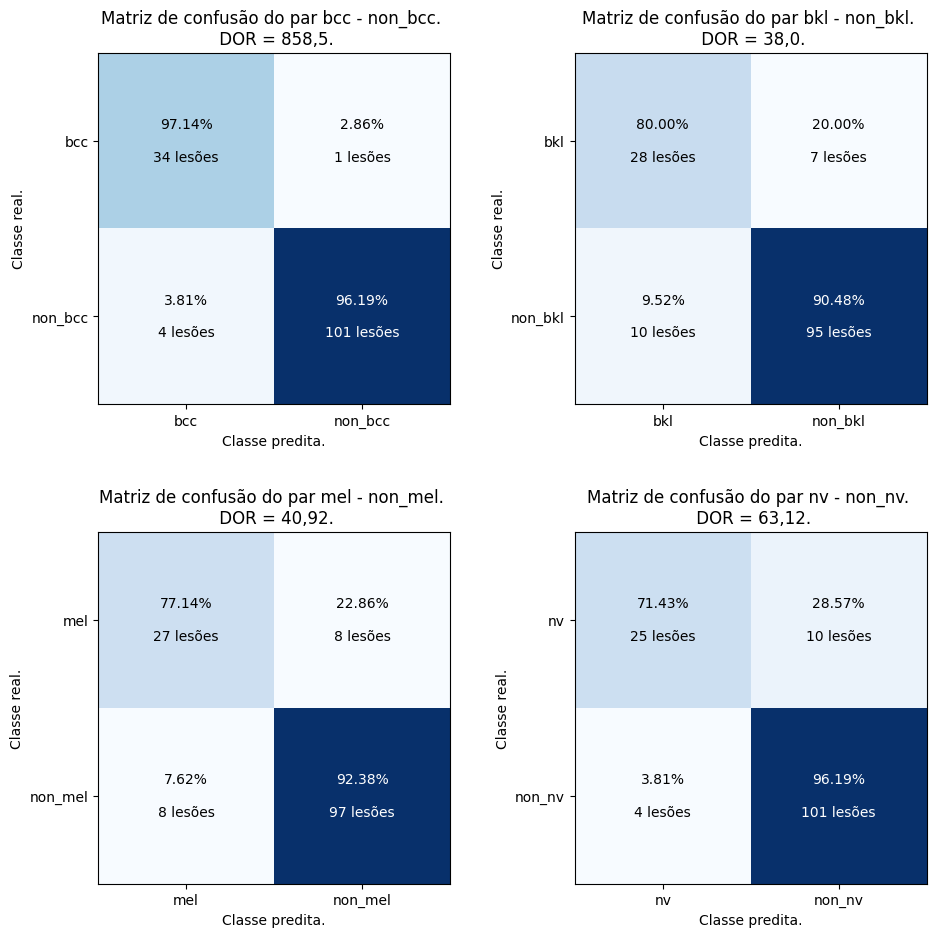

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/35, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/105, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

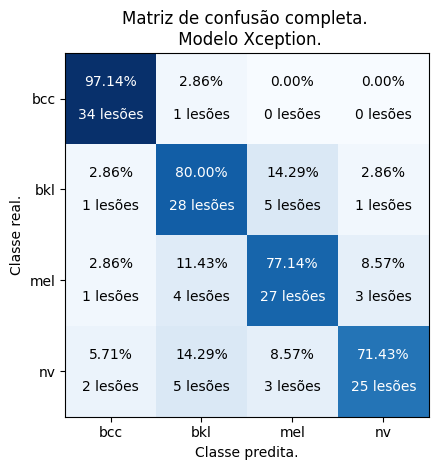

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*35, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

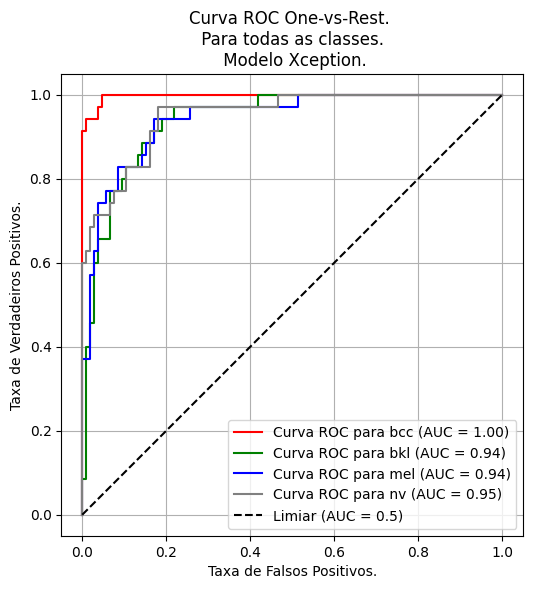

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2400 imagens*

Teste com um total de 2400 imagens, sendo, por classe, 1800 para treinamento, 480 para validação e 120 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

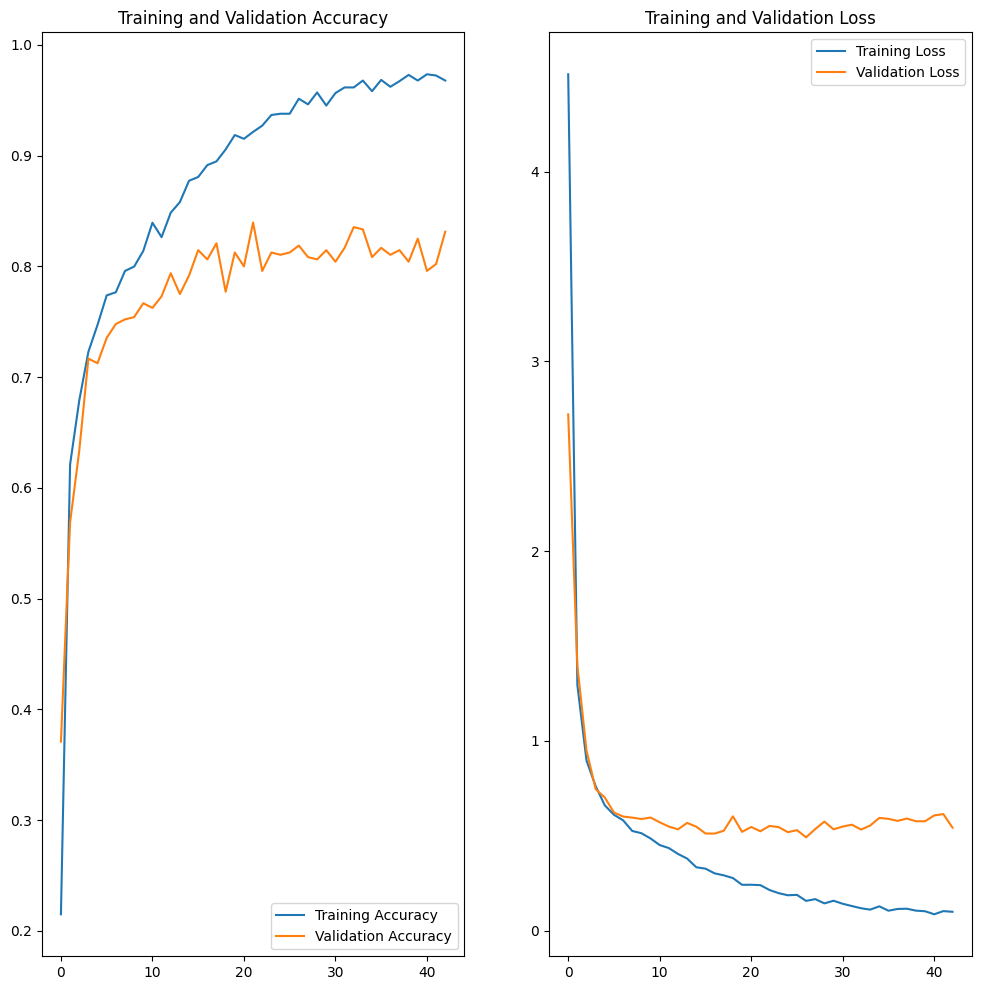

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(43)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

4/4 [==============================] - 4s 987ms/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

4/4 [==============================] - 3s 394ms/step - loss: 0.5696 - accuracy: 0.8000
              precision    recall  f1-score   support

         bcc       0.97      0.93      0.95        30
         bkl       0.70      0.70      0.70        30
         mel       0.71      0.83      0.77        30
          nv       0.85      0.73      0.79        30

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.81      0.80      0.80       120



Erro: 0.57 
Acurácia: 0.80


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 30, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(30, 60, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(60, 90, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(90, 120, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

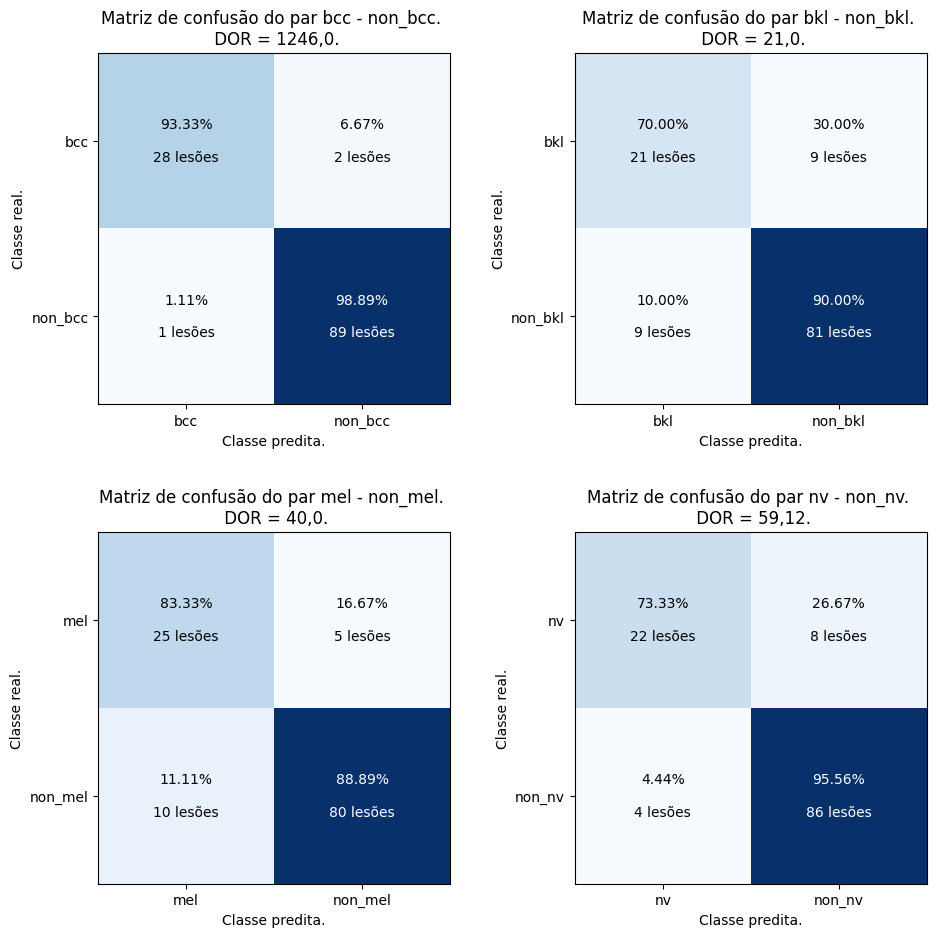

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/30, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/90, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

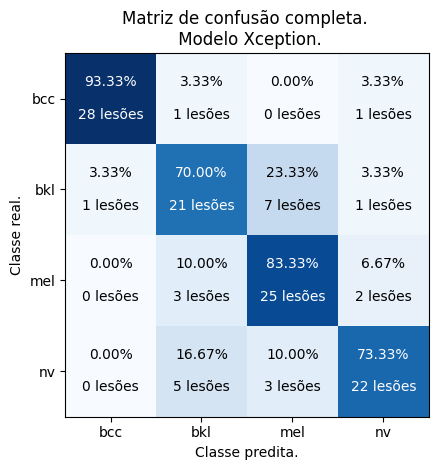

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*30, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

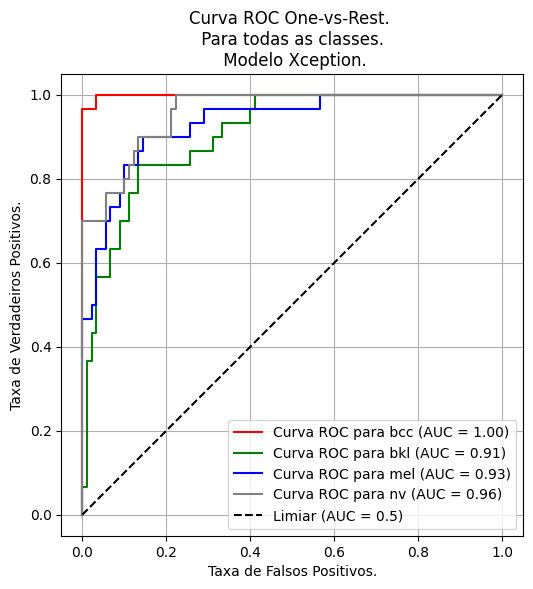

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2000 imagens*

Teste com um total de 2000 imagens, sendo, por classe, 1500 para treinamento, 400 para validação e 100 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

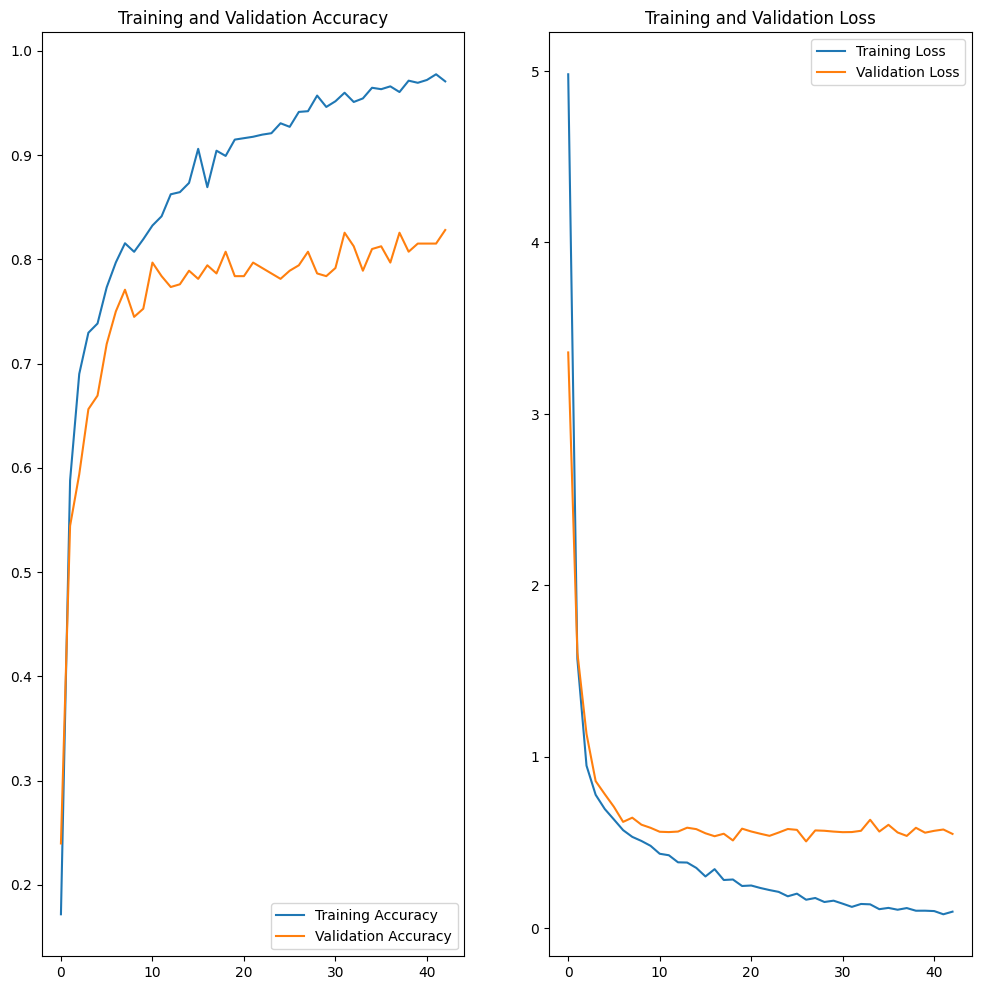

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(43)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

4/4 [==============================] - 2s 450ms/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

4/4 [==============================] - 2s 272ms/step - loss: 0.6060 - accuracy: 0.7900
              precision    recall  f1-score   support

         bcc       0.92      0.92      0.92        25
         bkl       0.67      0.80      0.73        25
         mel       0.77      0.80      0.78        25
          nv       0.84      0.64      0.73        25

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100



Erro: 0.61 
Acurácia: 0.79


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 25, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(25, 50, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(50, 75, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(75, 100, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

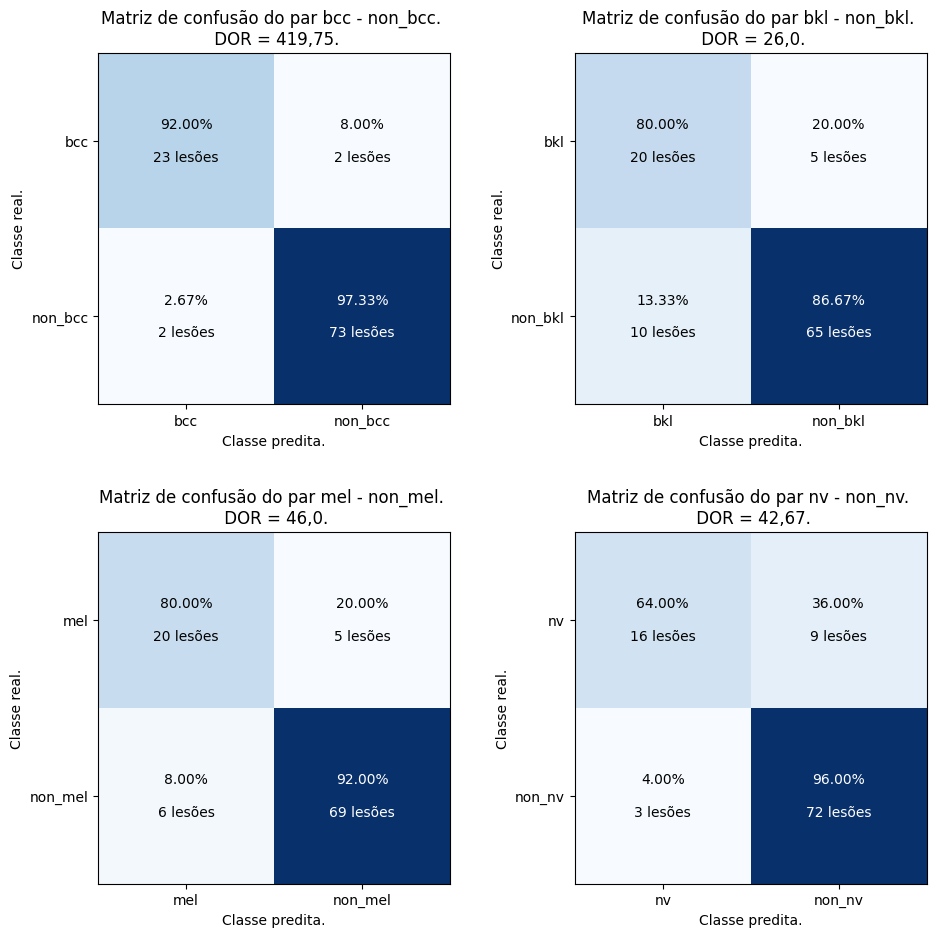

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/25, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/75, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

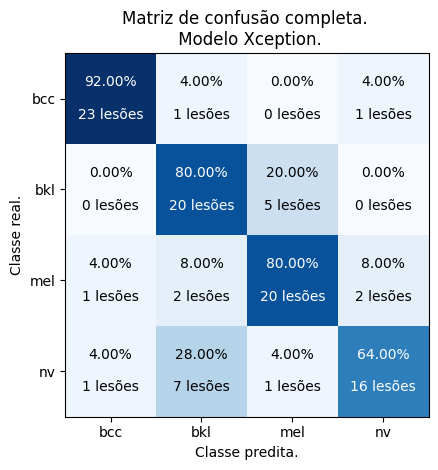

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*25, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

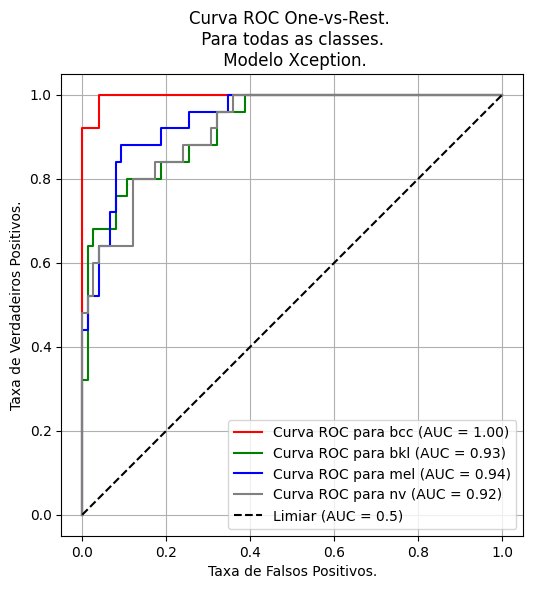

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 1600 imagens*

Teste com um total de 1600 imagens, sendo, por classe, 1200 para treinamento, 320 para validação e 80 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

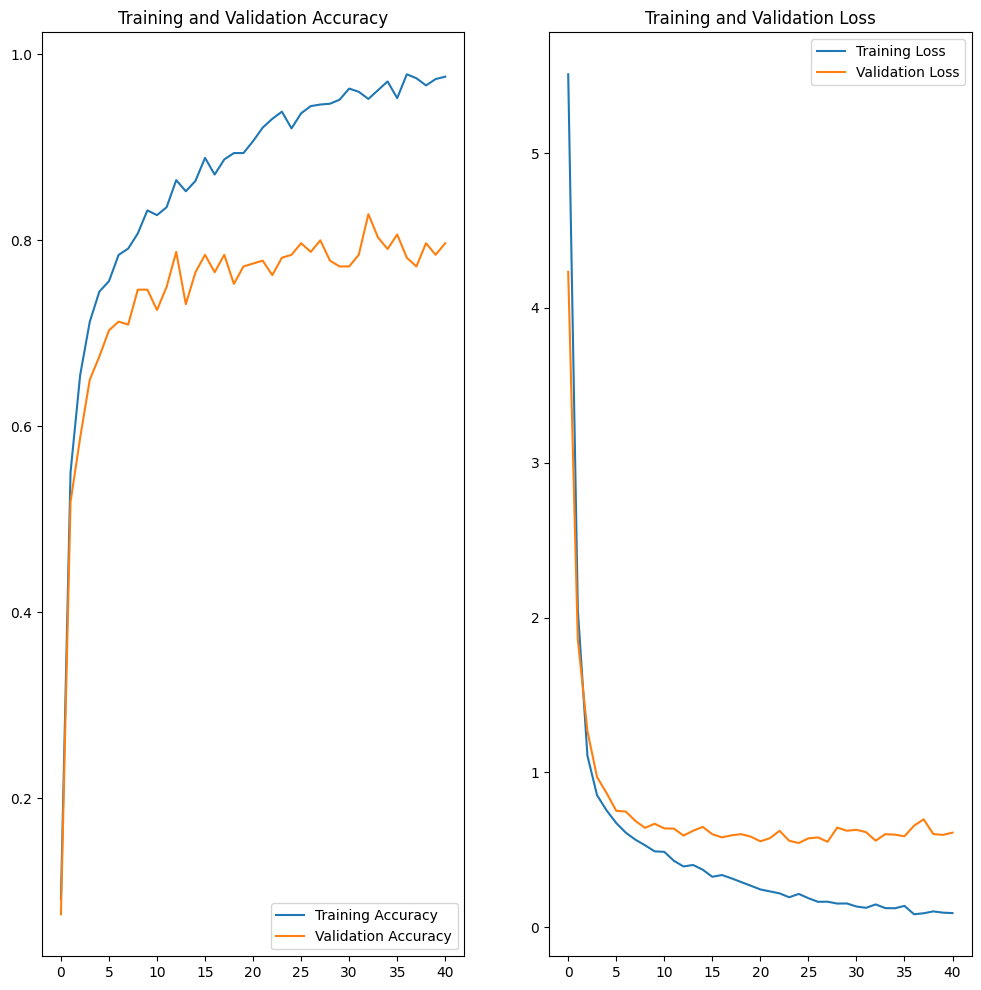

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(41)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

3/3 [==============================] - 1s 256ms/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

3/3 [==============================] - 2s 264ms/step - loss: 0.7143 - accuracy: 0.7500
              precision    recall  f1-score   support

         bcc       0.90      0.95      0.93        20
         bkl       0.62      0.75      0.68        20
         mel       0.75      0.75      0.75        20
          nv       0.73      0.55      0.63        20

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



Erro: 0.71 
Acurácia: 0.75


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 20, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(20, 40, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(40, 60, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(60, 80, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

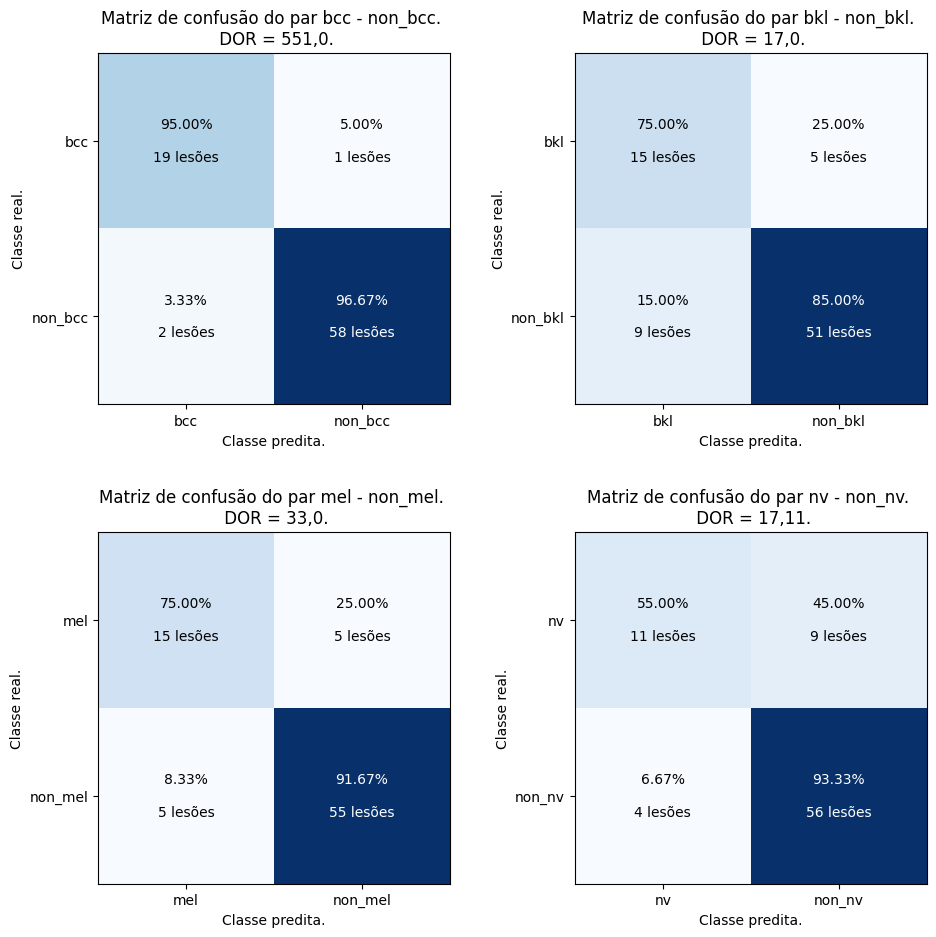

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/20, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/60, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

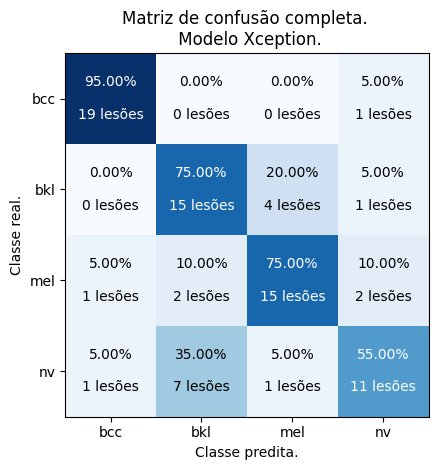

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*20, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

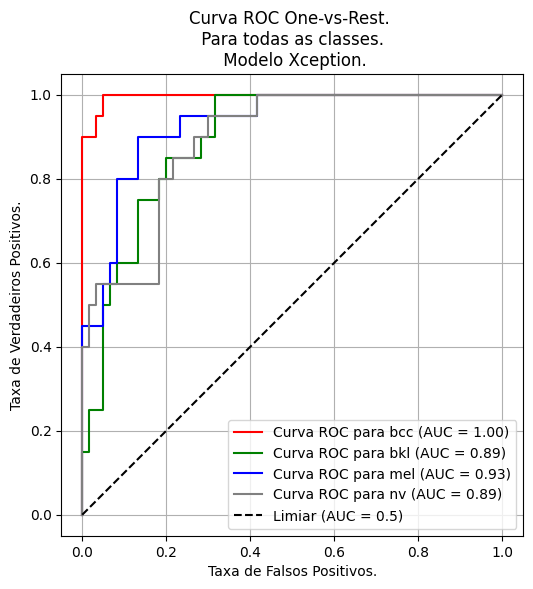

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 1200 imagens*

Teste com um total de 1200 imagens, sendo, por classe, 900 para treinamento, 240 para validação e 60 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

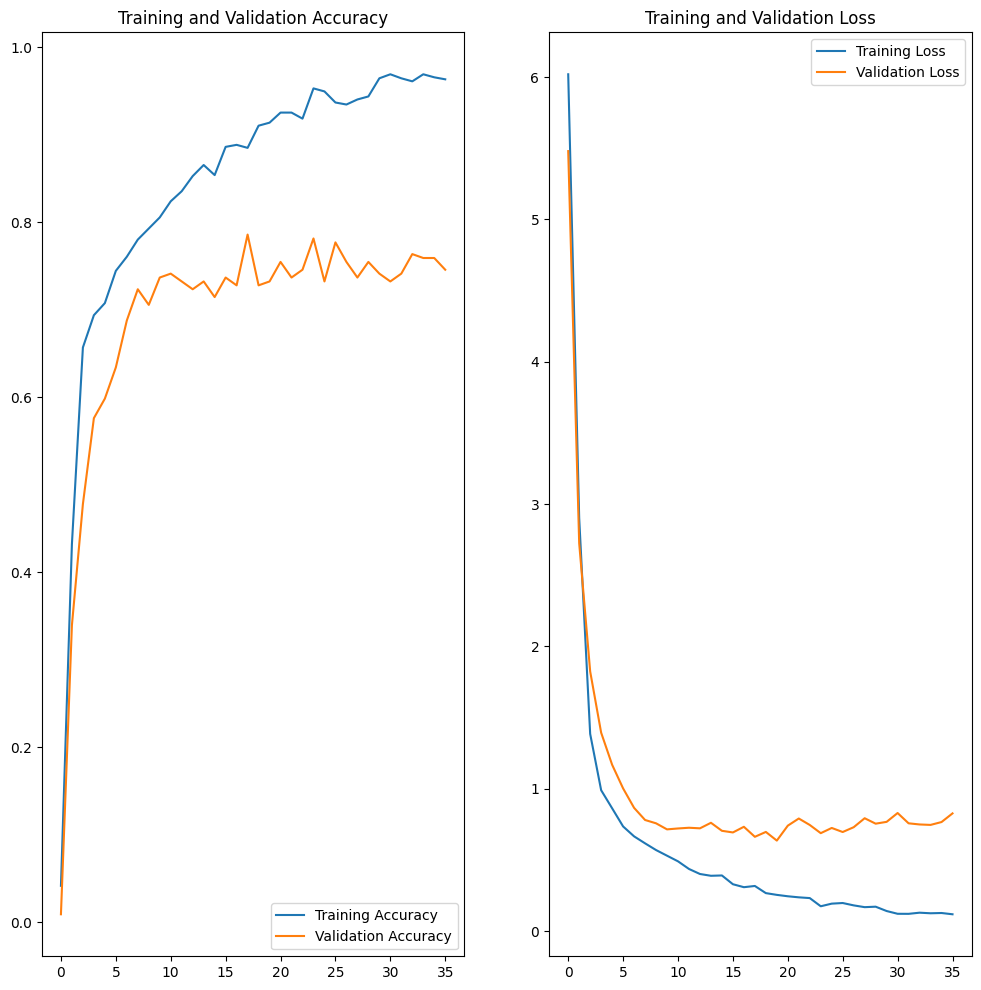

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(36)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_1200.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

2/2 [==============================] - 13s 2s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

2/2 [==============================] - 3s 1s/step - loss: 0.5377 - accuracy: 0.8333
              precision    recall  f1-score   support

         bcc       0.88      0.93      0.90        15
         bkl       0.71      0.80      0.75        15
         mel       0.83      0.67      0.74        15
          nv       0.93      0.93      0.93        15

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



Erro: 0.54 
Acurácia: 0.83


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 15, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(15, 30, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(30, 45, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(45, 60, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

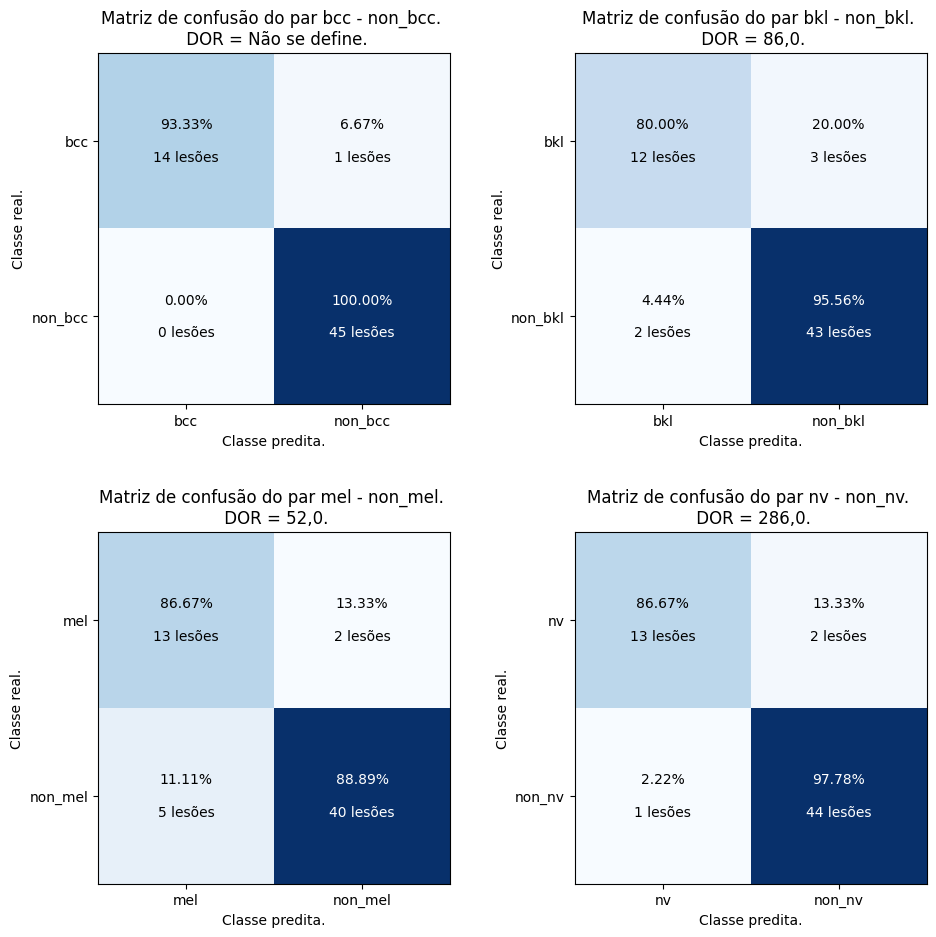

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/15, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/45, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

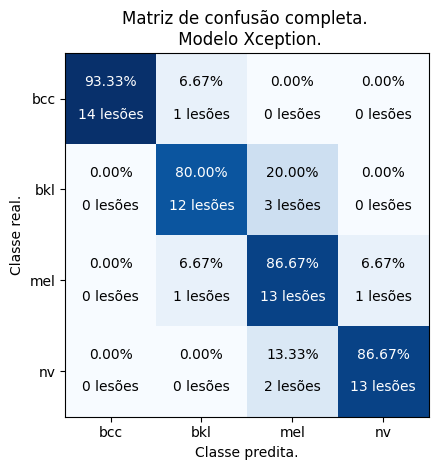

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*15, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

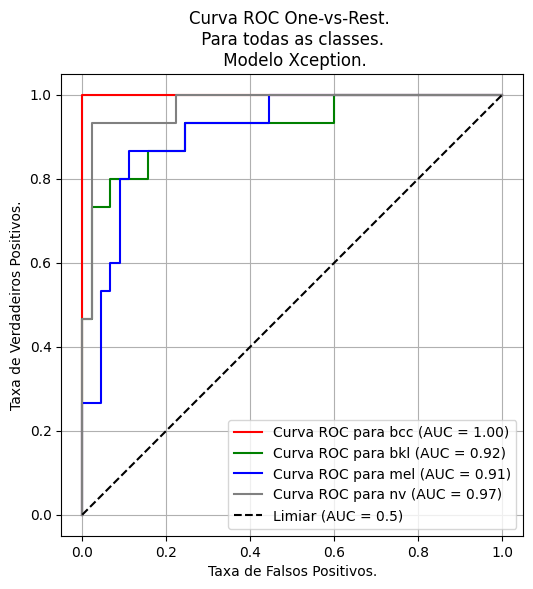

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 800 imagens*

Teste com um total de 1600 imagens, sendo, por classe, 1200 para treinamento, 320 para validação e 80 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

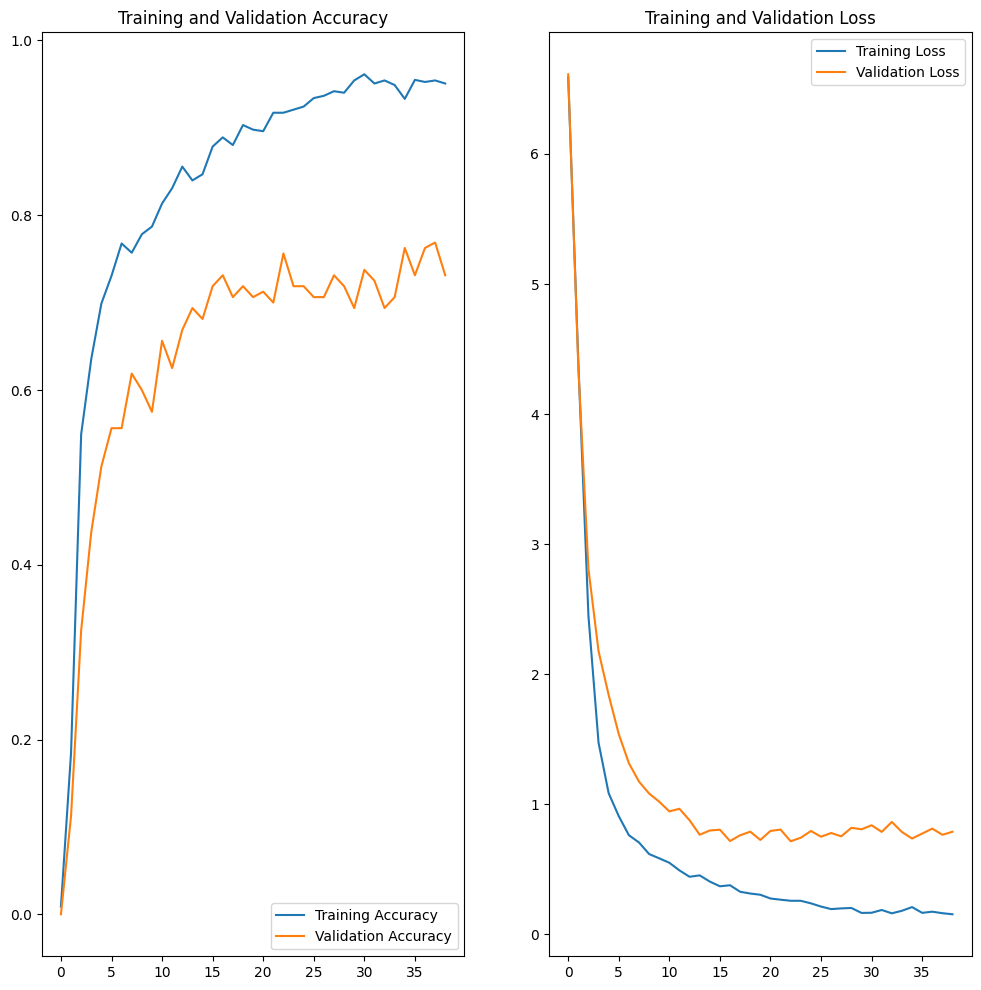

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(39)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_3600.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

2/2 [==============================] - 2s 1s/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

2/2 [==============================] - 1s 72ms/step - loss: 0.5574 - accuracy: 0.7500
              precision    recall  f1-score   support

         bcc       1.00      0.80      0.89        10
         bkl       0.62      0.50      0.56        10
         mel       0.62      0.80      0.70        10
          nv       0.82      0.90      0.86        10

    accuracy                           0.75        40
   macro avg       0.76      0.75      0.75        40
weighted avg       0.76      0.75      0.75        40



Erro: 0.56 
Acurácia: 0.75


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 10, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(10, 20, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(20, 30, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(30, 40, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

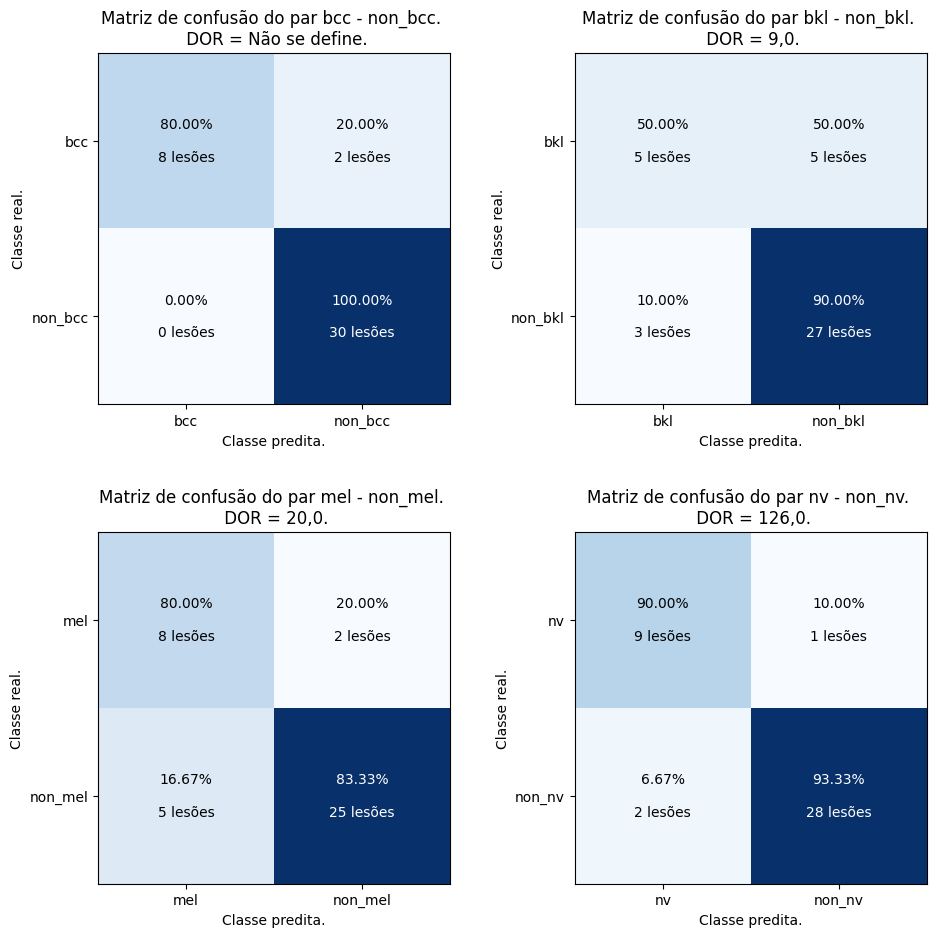

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/10, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/30, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

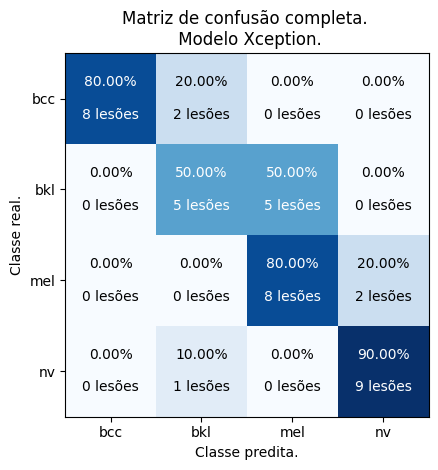

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*10, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

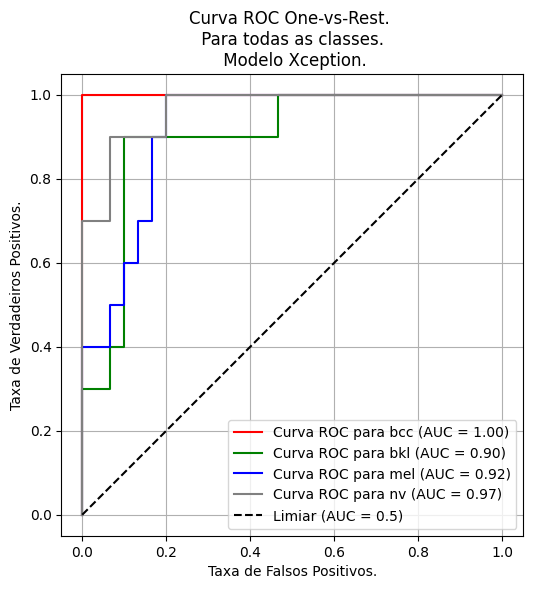

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 400 imagens*

Teste com um total de 1600 imagens, sendo, por classe, 1200 para treinamento, 320 para validação e 80 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

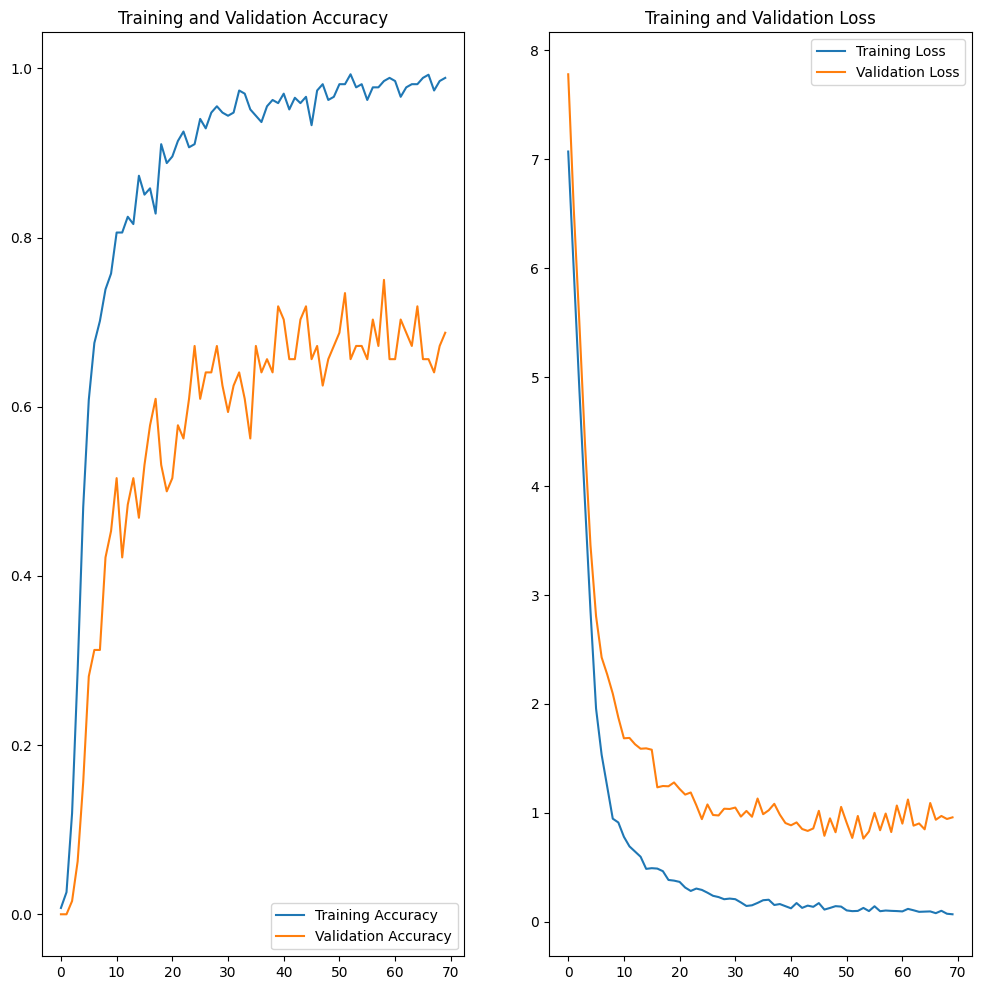

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(70)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#path_check_point_Xception = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo Xception/Checkpoint_modelXception_400.hdf5"
#Carregando o melhor conjunto de pesos
model_test_Xception = tf.keras.models.load_model(path_check_point_Xception)

#Realizando a predição no modelo treinado
y_predict = model_test_Xception.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

1/1 [==============================] - 2s 2s/step


In [ ]:
model_test_Xception.summary()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_Xception.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

1/1 [==============================] - 3s 3s/step - loss: 0.7369 - accuracy: 0.7500
              precision    recall  f1-score   support

         bcc       1.00      1.00      1.00         5
         bkl       0.50      0.40      0.44         5
         mel       0.57      0.80      0.67         5
          nv       1.00      0.80      0.89         5

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.75        20
weighted avg       0.77      0.75      0.75        20



Erro: 0.74 
Acurácia: 0.75


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 5, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(5, 10, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(10, 15, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(15, 20, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

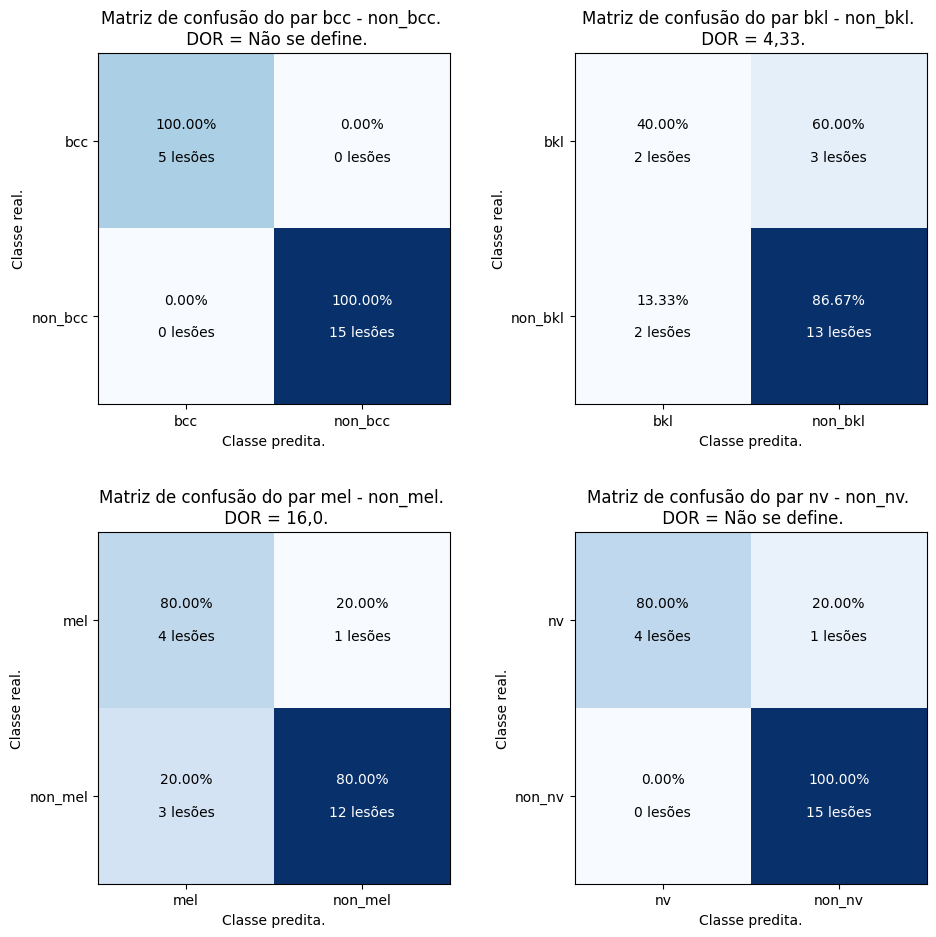

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/5, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/15, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

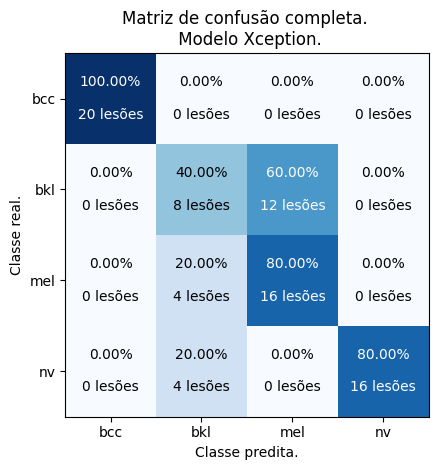

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo Xception.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*20, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

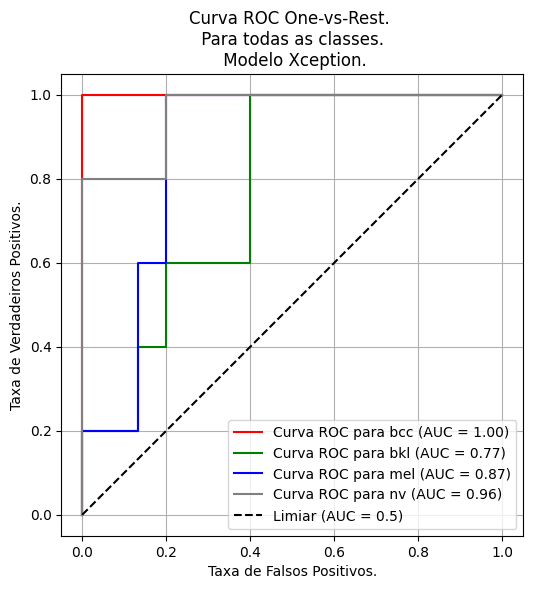

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo Xception.")
plt.legend()
plt.grid()
plt.show()